In [195]:
import torch
import torch.nn as nn


## Problem 1: Skip Connection Unet Architecture

In [196]:
class FirstFeature(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FirstFeature, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.conv = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
        )
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.conv(x)
        x = torch.concat([x, skip], dim=1)
        x = self.conv_block(x)
        return x


class FinalOutput(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FinalOutput, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv(x)


class Unet(nn.Module):
    def __init__(
            self, n_channels=3, n_classes=3, features=[64, 128, 256, 512],
    ):
        super(Unet, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes

        self.in_conv1 = FirstFeature(n_channels, 64)
        self.in_conv2 = ConvBlock(64, 64)

        self.enc_1 = Encoder(64, 128)
        self.enc_2 = Encoder(128, 256)
        self.enc_3 = Encoder(256, 512)
        self.enc_4 = Encoder(512, 1024)

        self.dec_1 = Decoder(1024, 512)
        self.dec_2 = Decoder(512, 256)
        self.dec_3 = Decoder(256, 128)
        self.dec_4 = Decoder(128, 64)

        self.out_conv = FinalOutput(64, n_classes)


    def forward(self, x):
        x = self.in_conv1(x)
        x1 = self.in_conv2(x)
        x2 = self.enc_1(x1)
        x3 = self.enc_2(x2)
        x4 = self.enc_3(x3)
        x5 = self.enc_4(x4)
        x = self.dec_1(x5, x4)
        x = self.dec_2(x, x3)
        x = self.dec_3(x, x2)
        x = self.dec_4(x, x1)
        x = self.out_conv(x)
        return x

In [197]:
unet_model = Unet()
img = torch.ones(2, 3, 256, 256)
unet_model(img).shape

torch.Size([2, 3, 256, 256])

## TEST KẾT QUẢ VỚI ẢNH

### 1. Cài đặt và import các thư viện cần thiết:

In [198]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


### 2. Tải và tiền xử lý ảnh:

In [199]:
# Định nghĩa transform để resize ảnh về kích thước phù hợp (ví dụ 256x256) và chuyển thành tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize ảnh về 256x256
    transforms.ToTensor(),          # Chuyển ảnh thành tensor
])

# Tải ảnh
image_path = "Standing_jaguar.jpg"
image = Image.open(image_path).convert("RGB")  # Chuyển ảnh sang RGB
input_tensor = transform(image).unsqueeze(0)   # Thêm batch dimension


### 3. Khởi tạo mô hình và chạy dự đoán:

In [200]:
# Khởi tạo mô hình
model = Unet(n_channels=3, n_classes=3)  # Nếu mô hình của bạn có số đầu ra khác, hãy điều chỉnh n_classes
model.eval()  # Chuyển mô hình sang chế độ đánh giá

# Chạy dự đoán
with torch.no_grad():
    output = model(input_tensor)


### 4. Chuyển đổi đầu ra về ảnh và hiển thị:

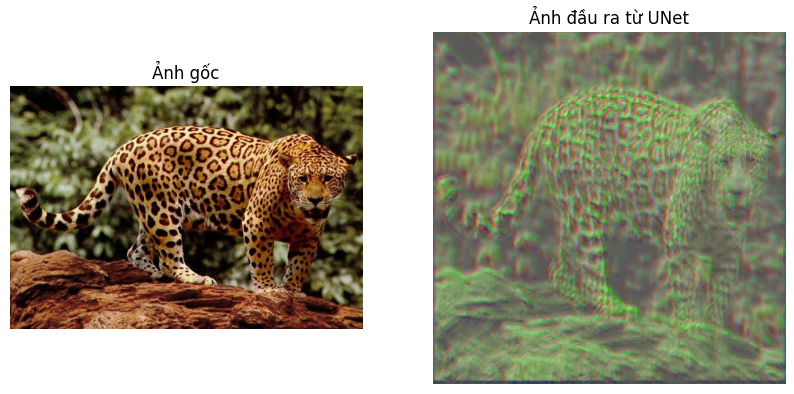

In [201]:
# Chuyển đổi tensor thành ảnh numpy
output_image = output.squeeze(0).permute(1, 2, 0).numpy()  # Đưa về (H, W, C)
output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())  # Chuẩn hóa về [0,1]

# Hiển thị ảnh gốc và ảnh đầu ra từ mô hình
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Ảnh gốc")
ax[0].axis("off")

ax[1].imshow(output_image)
ax[1].set_title("Ảnh đầu ra từ UNet")
ax[1].axis("off")

plt.show()
